## Алгоритм градиентного бустинга_6 урок. ДЗ

1. Задание.
    - Для реализованной в методичке модели градиентного бустинга построить зависимости ошибки от количества деревьев при разных значениях шага градиента на одном графике и для разной глубины деревьев на другом. 
    - Сделать выводы о зависимости ошибки от этих гиперпараметров (шаг градиента, максимальная глубина деревьев, количество деревьев). 
    - Подобрать оптимальные значения этих гиперпараметров (минимум ошибки на тесте при отсутствии переобучения).

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

Используем один из "игрушечных" датасетов из той же библиотеки.

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

Напишем функцию, реализующую предсказание в градиентном бустинге.


$$a_{N}(x) = \sum^{N}_{n=1}\eta\gamma_{n}b_{n}(x).$$

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании 
    # прибавляются с шагом eta
    return np.array([sum([
        eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) 
                     for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction) ** 2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Тогда сдвиг будет равен $s =- L'(y, z)$. 

In [7]:
def bias(y, z):
    return - 2 * (z - y)

Реализуем функцию обучения градиентного бустинга.

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # eta - скорость обучения
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            z_train = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы, начиная со второго, обучаем на сдвиг
            tree.fit(X_train, bias(y_train, z_train))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [9]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {round(mean_squared_error(y_train, train_prediction))}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {round(mean_squared_error(y_test, test_prediction))}')

In [11]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.2

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [81]:
train_errors = []
test_errors = []
coefs = [1] * n_trees
max_depth = 3
eta = 0.1

for n_trees in range(1, 26): # разное кол-во деревьев
    trees, train_errors_, test_errors_ = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_errors.append(mean_squared_error(y_train, train_prediction))
    test_errors.append(mean_squared_error(y_test, test_prediction))

In [82]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 2519
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3256


In [17]:
import matplotlib.pyplot as plt

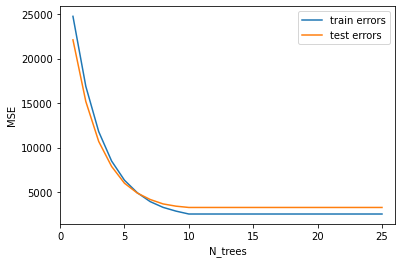

In [83]:
x = list(range(1, 26))

plt.xlim(0, 26)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N_trees')
plt.ylabel('MSE')
plt.legend(loc='upper right');

In [84]:
train_errors = []
test_errors = []
n_trees = 10
coefs = [1] * n_trees
eta = 0.1

for max_depth in range(1, 11): # разная глубина
    trees, train_errors_, test_errors_ = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_errors.append(mean_squared_error(y_train, train_prediction))
    test_errors.append(mean_squared_error(y_test, test_prediction))

In [85]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 10     с шагом 0.1 на тренировочной выборке: 462
Ошибка алгоритма из 10 деревьев глубиной 10     с шагом 0.1 на тестовой выборке: 4446


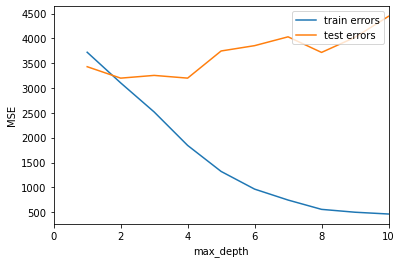

In [86]:
x = list(range(1, 11))

plt.xlim(0, 10)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend(loc='upper right');

In [74]:
train_errors = []
test_errors = []
coefs = [1] * n_trees
max_depth = 4
n_trees = 10

for eta in np.arange(0.05, 1, 0.05): # разный шаг
    trees, train_errors_, test_errors_ = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_errors.append(mean_squared_error(y_train, train_prediction))
    test_errors.append(mean_squared_error(y_test, test_prediction))

In [75]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 4     с шагом 0.9500000000000001 на тренировочной выборке: 1568
Ошибка алгоритма из 10 деревьев глубиной 4     с шагом 0.9500000000000001 на тестовой выборке: 10453


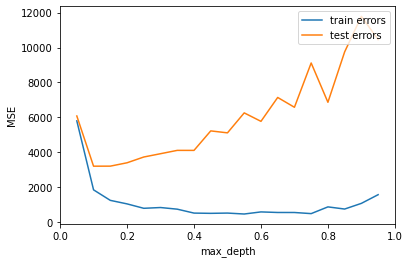

In [76]:
x = list(np.arange(0.05, 1, 0.05))

plt.xlim(0, 1)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend(loc='upper right');

### Исходя из проведенных вариантов: количества деревьев, при разных значениях шага градиента и для разной глубины, подберем оптимальное значение параметров и посмотрим:

In [96]:
# Число деревьев в ансамбле
n_trees = 9

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 2

# Шаг
eta = 0.1
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [97]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 9 деревьев глубиной 2     с шагом 0.1 на тренировочной выборке: 3386
Ошибка алгоритма из 9 деревьев глубиной 2     с шагом 0.1 на тестовой выборке: 3374


In [98]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(1, n_trees+1)), train_err, label='train error')
    plt.plot(list(range(1, n_trees+1)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

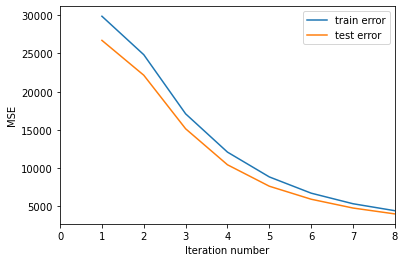

In [95]:
get_error_plot(n_trees, train_errors, test_errors)

### Вывод: Качество обучения улучшается, на мой взгляд неплохие результаты  подбора параметров!

2. (\*) Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5.    Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

In [65]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, rand_sample_size=0.5):
    
    trees = []
    
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        if len(trees) == 0:
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Рандомный выбор половины индексов
            to_choice = list(range(X_train.shape[0]))
            train_ind = np.random.choice(to_choice, size=int(0.5*len(to_choice)))
            
            # Получим ответы на текущей выбранной композиции
            target = gb_predict(X_train[train_ind], trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг, но не полный, а только части выборки
            tree.fit(X_train[train_ind], bias(y_train[train_ind], target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [66]:
n_trees = 10
coefs = [1] * n_trees
max_depth = 3
eta = 0.05

trees, train_errors_s, test_errors_s = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [67]:
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [68]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 6281
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 5836


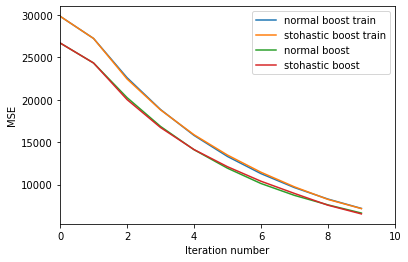

In [69]:
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
plt.plot(list(range(n_trees)), train_errors, label='normal boost train')
plt.plot(list(range(n_trees)), train_errors_s, label='stohastic boost train')
plt.plot(list(range(n_trees)), test_errors, label='normal boost')
plt.plot(list(range(n_trees)), test_errors_s, label='stohastic boost')
plt.legend(loc='upper right')
plt.show();

In [70]:
n_trees = 14
coefs = [1] * n_trees
max_depth = 3
eta = 0.1

trees, train_errors_s, test_errors_s = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [71]:
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [72]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 14 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1886
Ошибка алгоритма из 14 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3102


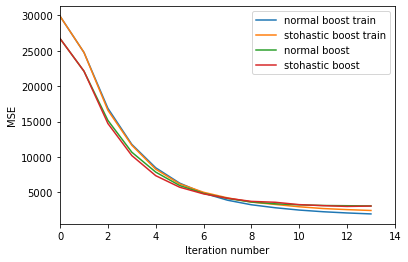

In [73]:
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
plt.plot(list(range(n_trees)), train_errors, label='normal boost train')
plt.plot(list(range(n_trees)), train_errors_s, label='stohastic boost train')
plt.plot(list(range(n_trees)), test_errors, label='normal boost')
plt.plot(list(range(n_trees)), test_errors_s, label='stohastic boost')
plt.legend(loc='upper right')
plt.show();

### Cудя по графику, сходимость при стахостическом бустинге не значительно отличается, можно сказать, что показывает более лучшие результаты и возможность избежать переобучения!